# For Demand Imputation Paper

The most final overimputation files provided by Dave F. are in `Oct5_Overimputations.zip` in my google drive `My Drive/Demand_Imputation/`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.imputation.mice as smi
import copy
import datetime
import matplotlib.dates as mdates
import matplotlib
from matplotlib.ticker import MultipleLocator
!conda list matplotlib

# packages in environment at /anaconda3:
#
# Name                    Version                   Build  Channel
matplotlib                3.1.1            py37h54f8f79_0    anaconda


In [16]:
# Load with various verbose summaries
def load_csv(file_path, columns, na_vals=['NA',], parse_d=True, verbose=0):
    dtype_map = {}
    for col in columns:
        dtype_map[col] = np.float64
    df = pd.read_csv(file_path,
                    dtype=dtype_map,
                    parse_dates=parse_d,
                    na_values=na_vals)
    if verbose >= 1:
        #print("\nHead(10)")
        #print(df.head(10))
        print("\nDescribe")
        print(df.describe().round(2))
        print("\ndf.isna().sum(axis=0)")
        print(df.isna().sum(axis=0))
    if verbose >= 2:
        plt.imshow(~df.isna(), aspect='auto')
        plt.xlabel("variables")
        plt.ylabel("cases")
        plt.gray()
        plt.show()
    if 'date_time' in df.columns:
        df['date_time'] = pd.to_datetime(df['date_time'])
    return df


def add_lags(df, regions):
    for r in regions:
        print("Adding lag for region {}".format(r))
        kwargs = {
                 '{}_Lag1'.format(r) : lambda x: np.roll(df[r], +1),
             }
        df = df.assign(**kwargs)
    return df

def drop_col(df, col):
    return df.drop(col, axis=1)


def return_imputed_indices(raw, name):
    index = pd.isnull(raw[name]).nonzero()[0]
    return index

def get_overimpute_index(raw, imp, col):
    init_nan = return_imputed_indices(raw, col)
    init_nan_set = set()
    for i in init_nan:
        init_nan_set.add(i)
    
    over_nan = return_imputed_indices(imp, col)
    over_nan_set = set()
    for i in over_nan:
        over_nan_set.add(i)
    
    return np.array(list(over_nan_set.difference(init_nan_set)))

def split_index_into_sort_and_long_gaps(index):
    short = []
    long = []
    index.sort()
    prev_was_short = False
    for i in range(len(index)-2): # Can't compare the last one like this
        if index[i+1] == index[i] + 1 and index[i+2] == index[i] + 2:
            long.append(index[i])
            prev_was_short = False
        else:
            short.append(index[i])
            prev_was_short = True
    if prev_was_short:
        short.append(index[-2])
        short.append(index[-1])
    else:
        long.append(index[-2])
        long.append(index[-1])
    return short, long
            
    

    
def return_values_by_index(imp, indices, name, replace_nan_with_zero=True):
    vals = imp.loc[indices, name]
    if replace_nan_with_zero:
        vals = vals.fillna(0)
    if len(vals) == 0:
        print("return_values_by_index returned ZERO values")
    return vals

def comparison_demand_plot(region, original, imp, imp_up, iqr_high, iqr_low, imp_down, imp_name, title, save, o_max):
    
    plt.close()
    matplotlib.rcParams.update({'font.size': 22})
    fig, ax = plt.subplots(figsize=(15,9))
    plt.subplots_adjust(left=.15, bottom=0.25, top=0.97, right=0.95)
    ax.set_ylabel('Demand (MW)')
    ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
    #plt.title(title)
    ax.plot(original['date_time'], original[region], 'k-', label='Demand', linewidth=3.0)
    ax.plot(original['date_time'], imp, 'r-', label='Imputed mean demand', linewidth=2.0)
    ax.fill_between(original['date_time'], imp_down, imp_up, facecolor='orange', alpha=0.6, label='Full imputed range')
    ax.fill_between(original['date_time'], iqr_low, iqr_high, facecolor='blue', label='IQR of imputed range')
    ax.plot(original['date_time'], original[region], 'k-', label='_nolegend_', linewidth=3.0)
    #ax.set_ylim(0, o_max*1.3)
    ax.set_ylim(0, ax.get_ylim()[1]*1.3)
    plt.legend(prop={'size': 24})  
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a\n%Y-%m-%d'))
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=90 )
    #ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.set_ylim(min(ax.get_ylim()[0], 0), ax.get_ylim()[1])
    #plt.tight_layout()
    plt.grid()
    plt.savefig(save+'.pdf')

# Create many demand plots so we can actually see the values
def scrolling_demand(width, region, original, imps, imp_mean, imp_name, title, save, tgt_itr=-1):
    start = 0
    end = width-1
    if region == 'CISO':
        start += 120
        end += 120
    k = 0
    tot_l = len(original.index)
    o_max = np.nanmax(original[region])
    while True:
        print(k, start, end)
        s = save.replace('.pdf', '_{}cnt'.format(k))
        t = title+': cnt {}'.format(k)
        o = original.loc[start:end]
        imp_avg = imp_mean.loc[start:end]
        
        
        # Max and min
        imp_max = []
        iqr_high = []
        iqr_low = []
        imp_min = []
        end_l = end if end == len(original.index) else end+1
        
        if tgt_itr == -1 or k == tgt_itr:
            for j in range(start, end_l):
            
                #print(j)
                vals = []
            
                for cnt, imp in enumerate(imps):
                    #print(f"{j} {cnt} --- max {max_}: min {min_}")
                    vals.append(imp.iloc[j][region])
                
                iqr_high.append(np.percentile(vals, 75))
                iqr_low.append(np.percentile(vals, 25))
                imp_max.append(max(vals))
                imp_min.append(min(vals))

                
        
            # Don't waste a plot if no imputation happened
            if not (o[region].equals(imp_avg[region])):
                print(f"Actually plotting for hours: {start}, {end}")
                comparison_demand_plot(region, o, imp_avg[region], imp_max, iqr_high, iqr_low, imp_min, imp_name, t, s, o_max)
        if end == tot_l:
            break
        k += 1
        start += width
        end += width
        if end >= tot_l:
            end = tot_l
        
        # Speed this up
        if region == 'CISO' and k > 105: break
        if region == 'LDWP' and k > 7: break








def comparison_scatter_plot(v1s, v2s, labels, t1, t2, title, save, float_y_min=False):

    plt.close()
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_xlabel(t1)
    ax.set_ylabel(t2)
    max_v1s = np.max( list(map(lambda x: np.max(x), v1s)))
    max_v2s = np.max( list(map(lambda x: np.max(x), v2s)))
    ax.set_xlim(0, max_v1s*1.1)
    min_v2s = 0
    if float_y_min:
        min_v2s = np.min( list(map(lambda x: np.min(x), v2s)))
    ax.set_ylim(min_v2s, max_v2s*1.1)
    plt.title(title)
    for v1, v2, l in zip(v1s, v2s, labels):
        ax.plot(v1, v2, '.', label=l, alpha=0.2)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.grid()
    plt.savefig(save)


def simple_resolution(df_true, df_imp, title, save, n_bins=20):

    plt.close()
    #if df_true.index.all() != df_imp.index.all():
    #    print("Indices do not align, exiting simple_resolution")
    #    return 0

    #res_grid = []
    #for index, value in df_true.items():
    #    if value > 0:
    #        res_grid.append( (df_imp.at[index]-value) / value)
    #    else:
    #        print("Value == 0 for simple_resolution {} {}".format(title, save))
    res_grid = []
    for obs, val in zip(df_true, df_imp):
        if obs != 0:
            res_grid.append((val-obs)/obs)
        else:
            print("Value == 0 for simple_resolution {} {}".format(title, save))
    
    fig, ax = plt.subplots(figsize=(5,5))
    n, bins, patches = ax.hist(res_grid, n_bins, 
            facecolor='b', alpha=0.5, density=False)
    print("Length simp_res {}".format(np.sum(n)))
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.title(title)
    plt.xlabel('(Imp. - Obs.)/Obs.')
    plt.ylabel('Counts')
    plt.tight_layout()
    plt.grid()
    plt.savefig(save)


def bplot_ylim(ax):
    current_ylim = ax.get_ylim()
    if current_ylim[0] > -0.1 and current_ylim[1] < 0.1:
        ax.set_ylim(-0.1, 0.1)
    elif current_ylim[0] > -0.15 and current_ylim[1] < 0.15:
        ax.set_ylim(-0.15, 0.15)

        
        
        
def get_mape_list(df_master, df_true, df_imp):
    mape_list = []
    mean_list = []
    
    for obs, val in zip(df_true, df_imp):
        res = (val-obs)/obs
        mape_list.append( abs(res) )
        mean_list.append( res )
    
    return mape_list, mean_list

        
# df_master is used to get the correct UCT time
def resolution_by_time(df_master, idx_vals, df_true, df_imp, title, save):
    
    plt.close()
    matplotlib.rcParams.update({'font.size': 18})
    
    #if df_true.index.all() != df_imp.index.all():
    #    print("Indices do not align, exiting resolution_by_time")
    #    return 0
    
    # Get UCT time by index
    zero_index_hour = df_master.at[0, 'date_time'].hour
    
    res_grid = []
    for i in range(24):
        res_grid.append([])
    month_grid = []
    for i in range(12):
        month_grid.append([])
    week_grid = []
    for i in range(7):
        week_grid.append([])
    year_grid = []
    for i in range(6):
        year_grid.append([])
    
    #print(idx_vals, df_true, df_imp)
    for idx, obs, val in zip(idx_vals, df_true, df_imp):
        #print(idx, obs, val)
        mod = (idx + zero_index_hour)%24 # Do UTC (Nov 5, 2019) - 8)%24 # -8 for PST vs. UCT
        res = (val-obs)/obs
        #print(res)
        #print(res_grid, mod, res)
        res_grid[mod].append(res)
        # Get month
        month = df_master.at[idx, 'date_time'].month
        month_grid[month-1].append(res)
        # Get week
        day = df_master.at[idx, 'date_time'].weekday()
        week_grid[day].append(res)
        year = df_master.at[idx, 'date_time'].year
        year_grid[year - 2015].append(res) # minus 2015 to zero index

    medianprops = dict(linestyle='-', linewidth=2.5)
    matplotlib.rcParams.update({'font.size': 22})
    rot = 90
    y_lab = '(imputed - actual)/actual'
    multiple = 0.05
    # Plot hourly
    plt.close()
    fig, ax = plt.subplots(figsize=(10,7))
    plt.subplots_adjust(left=.15, bottom=0.2, top=0.97, right=0.95)
    ax.yaxis.grid(True)
    #ax.set_title(title+': whiskers at 5%/95%')
    bplot = ax.boxplot(res_grid, whis=[5, 95], showfliers=False, patch_artist=True, medianprops=medianprops)
    hour_labels = []
    for i in range(24):
        if i%2==0:
            hour_labels.append('{0:02d}:00'.format(i))
        else:
            hour_labels.append('')
    plt.xticks([i for i in range(1, 25)], hour_labels, rotation=rot)
    ax.set_xlabel('Hour (UTC)')
    ax.set_ylabel(y_lab)
    ax.yaxis.set_major_locator(MultipleLocator(multiple))
    #plt.tight_layout()
    for patch in bplot['boxes']:
        patch.set_facecolor('lightblue')
    bplot_ylim(ax)
    plt.savefig(save)
    
    # Plot monthly
    plt.close()
    fig, ax = plt.subplots(figsize=(10,7))
    plt.subplots_adjust(left=.15, bottom=0.2, top=0.97, right=0.95)
    ax.yaxis.grid(True)
    #ax.set_title(title.replace('hour', 'month')+': whiskers at 5%/95%')
    bplot = ax.boxplot(month_grid, whis=[5, 95], showfliers=False, patch_artist=True, medianprops=medianprops)
    plt.xticks([i for i in range(1, 13)], ('Jan','Feb','Mar','Apr','May','Jun',
                                          'Jul','Aug','Sep','Oct','Nov','Dec'), rotation=rot)
    ax.set_ylabel(y_lab)
    ax.yaxis.set_major_locator(MultipleLocator(multiple))
    #plt.tight_layout()
    for patch in bplot['boxes']:
        patch.set_facecolor('lightblue')
    bplot_ylim(ax)
    plt.savefig(save.replace('hour', 'month'))
    
    # Plot weekly
    plt.close()
    fig, ax = plt.subplots(figsize=(10,7))
    plt.subplots_adjust(left=.15, bottom=0.2, top=0.97, right=0.95)
    ax.yaxis.grid(True)
    #ax.set_title(title.replace('hour', 'week')+': whiskers at 5%/95%')
    bplot = ax.boxplot(week_grid, whis=[5, 95], showfliers=False, patch_artist=True, medianprops=medianprops)
    plt.xticks([i for i in range(1, 8)], ('Mon','Tue','Wed','Thu','Fri','Sat','Sun'), rotation=rot)
    ax.set_ylabel(y_lab)
    ax.yaxis.set_major_locator(MultipleLocator(multiple))
    #plt.tight_layout()
    for patch in bplot['boxes']:
        patch.set_facecolor('lightblue')
    bplot_ylim(ax)
    plt.savefig(save.replace('hour', 'week'))
    
    # Plot yearly
    plt.close()
    fig, ax = plt.subplots(figsize=(10,7))
    plt.subplots_adjust(left=.15, bottom=0.2, top=0.97, right=0.95)
    ax.yaxis.grid(True)
    #ax.set_title(title.replace('hour', 'week')+': whiskers at 5%/95%')
    bplot = ax.boxplot(year_grid, whis=[5, 95], showfliers=False, patch_artist=True, medianprops=medianprops)
    plt.xticks([i for i in range(1, 7)], range(2015, 2021), rotation=rot)
    ax.set_ylabel(y_lab)
    ax.yaxis.set_major_locator(MultipleLocator(multiple))
    #plt.tight_layout()
    for patch in bplot['boxes']:
        patch.set_facecolor('lightblue')
    bplot_ylim(ax)
    plt.savefig(save.replace('hour', 'year'))

    
    
def return_all_regions():
    return ['AEC', 'AECI', 'CPLE', 'CPLW',
    'DUK', 'FMPP', 'FPC',
    'FPL', 'GVL', 'HST', 'ISNE',
    'JEA', 'LGEE', 'MISO', 'NSB',
    'NYIS', 'OVEC', 'PJM', 'SC',
    'SCEG', 'SEC', 'SOCO',
    'SPA', 'SWPP', 'TAL', 'TEC',
    'TVA', 'ERCO',
    'AVA', 'AZPS', 'BANC', 'BPAT',
    'CHPD', 'CISO', 'DOPD',
    'EPE', 'GCPD', 'IID',
    'IPCO', 'LDWP', 'NEVP', 'NWMT',
    'PACE', 'PACW', 'PGE', 'PNM',
    'PSCO', 'PSEI', 'SCL', 'SRP',
    'TEPC', 'TIDC', 'TPWR', 'WACM',
    'WALC', 'WAUW']
    
    
def return_good_regions():
    regions = return_all_regions()
    regions.remove('SEC')
    regions.remove('OVEC')
    return regions


Length of regions: 51
['ISNE', 'AEC', 'AECI', 'AVA', 'AZPS', 'BANC', 'BPAT', 'CHPD', 'CISO', 'CPLE', 'CPLW', 'DOPD', 'DUK', 'EPE', 'ERCO', 'FMPP', 'FPC', 'FPL', 'GCPD', 'GVL', 'HST', 'IID', 'IPCO', 'JEA', 'LDWP', 'LGEE', 'MISO', 'NEVP', 'NSB', 'NWMT', 'PACE', 'PACW', 'PGE', 'PJM', 'PNM', 'PSCO', 'PSEI', 'SC', 'SCL', 'SOCO', 'SPA', 'SRP', 'SWPP', 'TAL', 'TEPC', 'TIDC', 'TPWR', 'TVA', 'WACM', 'WALC', 'WAUW']
ISNE


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


AEC


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


AECI


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


AVA


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


AZPS


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


BANC


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


BPAT


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


CHPD


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


CISO


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


CPLE


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


CPLW


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


DOPD


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


DUK


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


EPE


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


ERCO


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


FMPP


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


FPC


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


FPL


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


GCPD


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


GVL


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


HST


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


IID


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


IPCO


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


JEA


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


LDWP


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


LGEE


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


MISO


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


NEVP


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


NSB


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


NWMT


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


PACE


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


PACW


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


PGE


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


PJM


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


PNM


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


PSCO


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


PSEI


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


SC


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


SCL


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


SOCO


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


SPA


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


SRP


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


SWPP


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


TAL


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


TEPC


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


TIDC


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


TPWR


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


TVA


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


WACM


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


WALC


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


WAUW


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


BA Median_Demand Num_for_Imp Mean_Diff Short Long All Forecast
ISNE 13588 5 -0.35100000000000003 1.44 2.16 1.73
AEC 481 331 -0.394 2.72 4.64 4.38
AECI 2308 14 0.40499999999999997 2.62 4.95 2.86
AVA 1369 457 0.35400000000000004 2.92 4.05 3.82
AZPS 3156 59 0.159 1.73 3.07 2.58
BANC 1873 1634 0.42900000000000005 1.67 4.06 3.92
BPAT 6212 54 0.211 1.03 1.89 1.38
CHPD 196 276 1.0330000000000001 2.94 10.84 6.4
CISO 24877 346 0.586 1.64 3.35 2.96
CPLE 6551 230 0.272 2.16 3.65 3.43
CPLW 556 246 -0.398 1.92 4.36 3.48
DOPD 177 2071 0.331 1.94 5.29 3.92
DUK 11340 48 -0.008 1.45 2.75 2.63
EPE 887 83 0.06999999999999999 1.44 4.11 1.8
ERCO 39433 240 0.559 3.51 5.63 5.51
FMPP 1956 805 -0.023 1.36 1.81 1.72
FPC 5725 108 0.029 0.95 1.67 1.37
FPL 13900 187 -0.293 1.38 2.66 2.14
GCPD 575 210 -0.107 0.76 2.58 0.83
GVL 217 3332 0.06 2.41 3.56 3.5
HST 63 1813 0.172 2.36 5.01 4.0
IID 349 876 0.34199999999999997 5.88 7.88 7.63
IPCO 1902 332 -0.905 2.85 6.6 5.26
JEA 1417 581 0.42900000000000005 2.2 3.78 3.63
LD

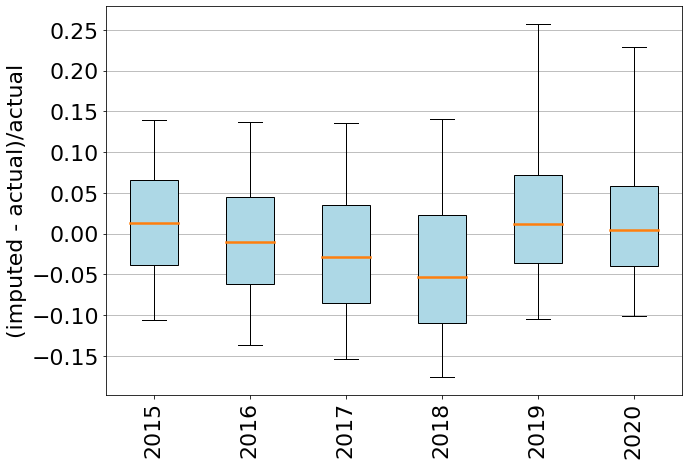

In [23]:
width = 240

n1 = 'MICE'
## Open a saved csv and check contents
base = '/Users/truggles/Downloads/Oct5_Imputations/'
png_out = '/Users/truggles/tmp_plots_imp_20201005/'

### NOTE, if you want ALL regions use regions = return_all_regions()
regions = ['BANC', 'CISO', 'LDWP', 'TIDC']
regions = ['CISO',]

do_box_plots = True
if not do_box_plots:
    print("\nOnly producing the scrolling demand plots\n")

    
app = '_28Sept2020_rm1July2015'
    
if do_box_plots:
    regions = ['BANC', 'CISO', 'LDWP', 'TIDC']
    regions = ['CISO',]
    df = load_csv(base+'csv_MASTER'+app+'.csv', regions, ['NA',], True, 0)
    #df = df.drop([i for i in range(19)])
    #df = df.drop([i for i in range(35064+19,36547)])
    df = df.reset_index()

    
    df['date_time'] = pd.to_datetime(df['date_time'])

    



    
regs = ['TAL','SCEG']#'NYIS','ERCO','PJM']
#regs = ['SCEG',]
regs = return_good_regions()
#regs = ['CISO',]
regs = [
     'ISNE',
     'AEC', 'AECI', 'AVA', 'AZPS', 'BANC', 'BPAT', 'CHPD', 'CISO', 'CPLE', 'CPLW', 'DOPD', 
     'DUK', 'EPE', 'ERCO', 'FMPP', 'FPC', 'FPL', 'GCPD', 'GVL', 'HST', 'IID', 'IPCO', 'JEA', 
     'LDWP', 'LGEE', 'MISO', 'NEVP', 'NSB', 'NWMT', #'NYIS', 
     'PACE', 'PACW', 'PGE', 'PJM', 
     'PNM', 'PSCO', 'PSEI', 'SC', #'SCEG', 
     'SCL', 'SOCO', 'SPA', 
     'SRP', 'SWPP', 'TAL', #'TEC', 
     'TEPC', 'TIDC', 'TPWR', 'TVA', 'WACM', 'WALC', 'WAUW']
    #'ISNE',
print( f"Length of regions: {len(regs)}" )
print(regs)
# Loop all regions
mape_map = {}
for r in regs:
    print(r)
    if not do_box_plots:
        break
    record = {
        'idx_short' : [],
        'idx_long' : [],
        
        'obs_short' : [],
        'obs_long' : [],

        'imp_short' : [],
        'imp_long' : [],
    }
    # Loop all imputed files
    all_mice = []
    
    mape_map[r] = {}
    
    for i in range(10):
        #print(f'{r} - adding mean file {i}')
        df_imp = load_csv(base+'csv_MASTER'+app+f'_overimpute_{i}.csv', regions, ['NA',], True, 0)
        #df_imp = df_imp.drop([i for i in range(19)])
        #df_imp = df_imp.drop([i for i in range(35064+19,36547)])
        df_imp = df_imp.reset_index()

        
        # Find index ONLY from overimputation
        over_index = get_overimpute_index(df, df_imp, r)

        # Split results by short vs long imputation gaps
        short_obs, long_obs = split_index_into_sort_and_long_gaps(over_index)
        
        df_mice = load_csv(base+f'mean_overimpute_csv_MASTER_{i}_mice_Oct5.csv', regions, ['NA',], True, 0)
   
        record['idx_short'].append(short_obs)
        record['idx_long'].append(long_obs)
        
        record['obs_short'].append(return_values_by_index(df, short_obs, r))
        record['obs_long'].append(return_values_by_index(df, long_obs, r))
        
        record['imp_short'].append(return_values_by_index(df_mice, short_obs, r))
        record['imp_long'].append(return_values_by_index(df_mice, long_obs, r))

    
    idxs = ['idx_short', 'idx_long']
    obss = ['obs_short', 'obs_long']
    imps = ['imp_short', 'imp_long']
    names = ['short', 'long']
    for name, idx, obs, imp in zip(names, idxs, obss, imps):
        idx_vals = np.concatenate(record[idx])
        obs_vals = pd.concat(record[obs])
        imp_vals = pd.concat(record[imp])


        resolution_by_time(df, idx_vals, obs_vals, imp_vals, 'overimp hourly resolution {} {} {}'.format(name, n1, r),
            f'{png_out}imp_resolution_hourly_{r}_{name}.png')
        
        info = get_mape_list(df, obs_vals, imp_vals)
        mape_map[r][name] = info[0]
        mape_map[r][name+'_mean'] = info[1]
    mape_map[r]['all'] = list(mape_map[r]['short'])
    mape_map[r]['all'].extend( list(mape_map[r]['long']) )
    mape_map[r]['all_mean'] = list(mape_map[r]['short_mean'])
    mape_map[r]['all_mean'].extend( list(mape_map[r]['long_mean']) )



    
if do_box_plots:
    print("BA Median_Demand Num_for_Imp Mean_Diff Short Long All Forecast")
    total = {'short': [], 'long': [], 'all': [], 'all_mean': []}
    tot_imp = 0
    tot_med = 0
    for r, d in mape_map.items():
        med = df[r].median()
        short_ = 100. * sum(d['short'])/len(d['short']) if len(d['short']) > 0 else np.nan
        long_ = 100. * sum(d['long'])/len(d['long']) if len(d['long']) > 0 else np.nan
        all_ = 100. * sum(d['all'])/len(d['all']) if len(d['all']) > 0 else np.nan
        mean_all = np.nanmean(d['all_mean']) if len(d['all_mean']) > 0 else np.nan
        total['short'].extend(d['short'])
        total['long'].extend(d['long'])
        total['all'].extend(d['all'])
        total['all_mean'].extend(d['all_mean'])
        tot_imp += sum(df[r].isna())
        tot_med += med
        #forecast = get_forecast(r)
        print(r, int(med), sum(df[r].isna()), 100. * round(mean_all,5), round(short_,2), round(long_,2), round(all_,2))#, round(forecast*100,2))
    print("CONUS", int(tot_med), tot_imp, 100. * round(np.nanmean(total['all_mean']),5),
        round(100. * sum(total['short'])/len(total['short']),2), 
        round(100. * sum(total['long'])/len(total['long']),2), 
        round(100. * sum(total['all'])/len(total['all']),2))
